In [1]:
import torch
from classifier import GraphEncoder, SupConLoss
import numpy as np
import pandas as pd
from torch_geometric.data import DataLoader, Dataset, Data
from tqdm import tqdm

In [2]:
NUM_NODE_FEATURES = 1
HIDDEN_DIM = 64
BATCH_SIZE = 32
epoch = 2

model = GraphEncoder(num_node_features=NUM_NODE_FEATURES, hidden_dim=HIDDEN_DIM)
model.load_state_dict(torch.load(f'graph_encoder_epoch_{epoch}.pth'))
model.eval()

GraphEncoder(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (projector): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
)

Create graphs from data

In [3]:
data = pd.read_parquet('../lba_data_expl/lba.parquet')

In [4]:
# use 'sample' = reference atlas for now
data = data[data['Sample'] == 'ReferenceAtlas']

# Discard indistinguishable lipids 
lipid_names = ['HexCer 42:2;O2', 'HexCer 42:1;O2', 'HexCer 40:1;O2', 'PC 38:6', 'PA 34:1', 'SM 36:1;O2', 'HexCer 40:2;O2', 'PG 40:6', 'PC 40:6', 'HexCer 36:1:O2', 'PE 40:6', 'PG 36:0', 'HexCer 41:1;O2', 'PE 42:9', 'PE 38:6', 'PC 40:7', 'PC 34:1 PC 36:4 PE 37:1 PE 39:4', 'LPE 22:6', 'PA 36:1', 'PE 40:7', 'PG 37:4', 'Cer 42:2;O2', 'Cer 40:2;O2', 'LPE 22:4', 'PA 40:6', 'PC 34:2', 'PC 40:1', 'PS 36:1', 'PC 35:1 PC O-38:7 PE 38:1 PE O-41:7', 'SM 42:1;O2', 'PI 36:4', 'SM 38:1;O2', 'PC 42:1', 'SM 34:1;O2', 'PE 40:4', 'PA 38:3', 'PG 36:2', 'PC 30:0', 'TG 67:2', 'TG 72:9', 'LPA 18:1', 'LPC O-16:2', 'LPC 16:0', 'LPC O-16:0', 'LPC O-18:2', 'LPE 18:1', 'LPS 16:0', 'LPE 18:0', 'LPC O-18:0', 'LPE 20:0', 'LPC 18:1', 'LPG 20:1', 'LPC 18:0', 'LPE 22:1', 'LPC 20:4', 'LPC 20:1', 'Cer 36:1;O2', 'LPC 22:6', 'Cer 40:1;O2', 'Cer 41:2;O2', 'Cer 40:0;O2', 'DG 35:0', 'Cer 42:1;O2', 'PA 32:1', 'PA 32:0', 'SM 31:1;O2', 'PE O-34:2', 'PC 31:0 PE 34:0', 'PA 36:1 PA 38:4', 'PE 32:2', 'HexCer 36:2;O2', 'PC 32:1', 'PC 32:0', 'PA 36:4', 'PA 36:2', 'PC 31:0 PE 34:0 PE 36:3', 'PA 38:5', 'PG 32:0', 'PE 36:1', 'PC O-34:1', 'PE 36:0', 'HexCer 36:1;O2', 'PS 32:1', 'HexCer 38:2;O2', 'SM 35:1;O2', 'PC 31:1 PE 34:1', 'PE O-36:0 PE O-38:3', 'PC O-32:0', 'PE O-38:2', 'PC 34:1', 'PE O-36:5', 'PC 34:0', 'PA 38:4', 'PE O-36:3', 'SM 36:2;O2', 'PE O-36:2', 'PE O-36:1', 'PC 35:1 PE 38:1', 'PA 40:4', 'PE O-38:7', 'PG 34:1', 'PG 35:0', 'PE O-38:6', 'PG 34:0', 'PC 37:5 PE 38:2 PE 40:5', 'HexCer 38:1;O2 PG 36:1', 'PC 35:0', 'PE 38:7', 'PS 34:1', 'PS 36:4', 'PC 37:1 PE 40:1', 'PS 36:3', 'PG 37:5', 'PE 38:4', 'PG 37:2', 'PC O-36:1', 'PG 37:1', 'SM 42:2;O2', 'PE O-40:7', 'PG 36:1', 'PS 38:1', 'PG 38:5', 'PC 39:6 PE 40:3 PE 42:6', 'PG 38:4', 'PG 39:0', 'SM 41:2;O2', 'PC 36:3', 'PG 38:3', 'PC 36:2', 'HexCer 40:0;O2', 'PS 36:2', 'PC 36:1', 'PG 38:1 PG 40:4', 'SM 42:3;O2', 'PS 36:0', 'PC 38:5', 'PS 38:5', 'PG 39:5', 'PG 39:4', 'PC 38:7', 'PG 40:5', 'PC 38:4', 'PG 40:4', 'PC 38:2', 'PC 38:1', 'PE 42:6', 'PS 41:0', 'PS 40:2', 'PS 40:6', 'PI 34:1', 'PS 40:5', 'PC 40:4', 'HexCer 44:2;O2', 'PI 34:0', 'PS 42:9', 'PC 40:2', 'PS 41:1', 'PI 36:3', 'PS 42:6', 'PI 36:1', 'PI 36:0', 'PS 44:9', 'PI 38:7', 'PI 39:5', 'PS 44:10', 'PI 38:5', 'PI 38:4', 'PI 40:8', 'PI 40:7', 'PI 40:5', 'PI 42:8', 'Hex2Cer 40:1;O2', 'Hex2Cer 40:0;O2']
for lipid in lipid_names:
    if len(lipid) > 14 and lipid[:7] != 'Hex2Cer':
        lipid_names.remove(lipid)
lipid_names.remove('PA 36:1 PA 38:4')
lipid_names.remove('PE O-36:0 PE O-38:3')
lipid_names.remove('HexCer 38:1;O2 PG 36:1')
lipid_names.sort()

lipizone_names = ['BA-AUDv1-PAA-GU1-MOs1', 'LM-VISC1-PVp-MMm-MMp', 'AP-ILA6b-ACAd6b-VISpl1-GR', 'SSp-un1-SSp-ul1-SSp-n1-SSp-m1-SSp-ll1', 'BA-AId1-PERI1-COAa-AIv1', 'PSTN-PAS', '_1', 'ENTm1-ECT1-MEPO-fx-VISrl1', 'FL-ARH-TU-PVp-MMp', 'MA-LM-BA-sup-VLPO', 'PVHd-GR-Xi-PVH-ARH', 'AUDd1-SSp-n1-GU1-MOp1-SSp-m1', 'MOp1-SSp-m1-AId2/3-SSp-ul1-AUDp1', 'MOp1-MOs2/3-MOp2/3-MOs1', 'Temporal association areas, layer 1', 'VISp1-VISrl1-RSPd2/3-RSPd1-VISp2/3', 'mammillary peduncle', 'VISa1-ACAd1-ACAd2/3-VISam2/3-FC', 'Medial preoptic nucleus', 'Paratrochlear nucleus', 'Vascular organ of the lamina terminalis_1', 'VISC1-AIp1-VISC2/3-AId1-SSp-tr1', 'TEa1-AId1-AIv1-AUDv1-ECT1', 'MOs1-SCzo-VISl1-RSPd2/3-RSPd1', 'Vascular organ of the lamina terminalis_2', '_3', 'cerebral aqueduct_1', 'AUDp1-VISal1-VISli1-VISl1-VISa1', 'PFL-FL-TMv-MMp-GU1', 'LC-uf-LT-TRS-cic', 'MPO-PSTN-MPN-AVP-mp', 'Taenia tecta, ventral part_3', 'ENTl1-AId1-AIv1-PERI1-ECT1', 'SSp-ul1-SSp-un1-SSp-m1-SSp-n1-SSp-tr1', 'AIv2/3-ACAd1-ACAd2/3-ECT5-TEa5', 'VISam5-MOs5-RSPagl5-VISa6a-VISam6a', 'VISl1-MOp1-SSp-ll1-VISli1-VISp1', 'VISrl1-VISrl2/3-VISal1-SSp-ll2/3-MOp1', 'Anteromedial visual area, layer 2/3', 'SSs1-SSp-bfd1-AUDd1-VISC2/3-VISpor1', 'SSp-ll1-SSp-un1-SSp-tr1-AUDd1-SSp-ul1', 'MOp2/3-VISpl5-IPL-MOs2/3', 'VISal1-RSPd2/3-VISpl2/3-SSp-m2/3-VISrl2/3', 'cerebral aqueduct_3', 'choroid plexus', 'VISl2/3-SSp-ll2/3-VISrl2/3-VISpl2/3-SSp-ul2/3', 'PCG-LC-LING-B-V4', 'MEPO-ARH-PAA-VL-PVp', 'AUDv2/3-VISpor2/3-TEa2/3-VISC2/3-AUDd1', 'VISpor4-VISal2/3-APr-VISpor2/3-VISli2/3', 'MOp2/3-PRE-ORBl2/3-VISal1-MOs2/3', 'Median preoptic nucleus', 'MMme-PVp', 'Dorsal auditory area, layer 2/3', 'SSp-bfd2/3-AUDd2/3-SSs2/3-VISli1-VISl2/3', 'Intermediate geniculate nucleus_2', 'RSPd6b-VISpm6b-RSPagl6b-PVp-SSp-bfd6b', 'SSp-n2/3-SSp-m2/3-AUDd4-SSp-un2/3-AUDp2/3', 'Primary somatosensory area, barrel field, layer 2/3', 'sV-sctd', 'cerebral aqueduct_2', 'AMBv-AMBd-PGRNl-LIN-PBG', 'PPY-VII-PG-cst-INC', 'VISa5-VISam5-SSp-tr5-ACAd2/3-VISpor5', 'VISrl4-VISrl2/3-AUDd2/3-VISal2/3-MOp2/3', 'SSp-ll4-VISpm2/3-SSp-tr4-VISli4-VISal4', 'SH-CEAc-LSr', 'AUDd4-VISal4-VISl4-VISa4-VISrl4', 'PRC-SPA', 'VISa6a-AUDd6a-VISal6a-PRE-AUDd5', 'PVp-SUV-VeCB-PPT-ISN', 'IntG-VPL-INC-FF-SCiw', 'AVP-PSTN', 'Postrhinal area, layer 4', 'Anteromedial visual area, layer 5_1', 'VISli2/3-VISpor4-VISpor2/3-AUDpo2/3-AUDpo4', 'VISli6a-VISl6a-AUDpo6a-VISam5-SSp-ll5', 'Anterolateral visual area, layer 4', 'VISpm1-RSPagl2/3-VISam2/3-ORBvl6a-ACAv5', 'VISli6b-VISa6a-VISli6a-RSPagl6a-AUDpo6a', 'PIR-ENTm6-AIp1-ENTl2-ECT2/3', 'SH-DG-po-DG-sg-MGd-CA3', 'VISa6a-VISam5-MOs5-VISam6a-AUDd5', 'AUDd4-VISp2/3-AUDp2/3-AUDd2/3-VISrl1', 'SSp-ll4-VISam5-VISa5-VISal5-VISl5', 'BLAv-ee-BMAp-ARH', 'RH-ORBvl5-PVT-IAM-PA', 'VISam5-VISam2/3-VISa5-SSp-tr5-VISli5', 'SSp-bfd5-VISp5-VISpm2/3-IPL-SSs5', 'GU1-COApm-PAA-HATA-AId1', 'VISl5-VISli5-VISl4-VISpm4-AUDpo5', 'SSp-n2/3-SSp-m2/3-SSp-un2/3-SSp-ul2/3-SSp-bfd2/3', 'VISpl5-RSPd2/3', 'ORBl2/3-ACAv2/3-ACAv1-ACAv5-ACAd1', 'VISal4-VISrl4-VISpm4-VISpm2/3-VISli4', 'Anteromedial visual area, layer 5_2', 'SCzo-SCsg-RSPv2/3-RSPv1-RSPv5', 'VISal5-VISl6a-AUDd5-VISrl5-VISal6a', 'Laterointermediate area, layer 4', 'VISa6a-VISl6a-ORBl5-VISp6a-MOs5', 'VISal4-VISrl4-AUDd4-VISp4-AUDpo4', 'ENTl2-ENTl1-PERI1-AIp1-COAa', 'VISl2/3-VISli4-AUDpo2/3-VISli2/3-AUDpo4', 'Paramedian lobule', 'IPC-IPI', 'SSs4-SSp-ul4-SSp-un4-VISrl4-SSp-m4', 'VISli5-VISl5-VISam2/3', 'PVHd-PVH-Xi-AHN-CEAl', 'Primary somatosensory area, nose, layer 2/3', 'Lateral septal nucleus, caudal (caudodorsal) part', 'SSp-bfd4-VISl4-VISp4-VISa4-AUDd4', 'VISpm5-VISrl5-SSp-ul4-VISal5-SSp-ll4', 'RSPv2/3-AUDp5-SSp-bfd5-RSPv5-SSp-n5', 'Taenia tecta, ventral part_2', 'AId1-ENTl1-AIp1', 'SSp-n2/3-VISp2/3-SSp-bfd2/3-VISl4-SSp-bfd4', 'AUDd5-VISrl5-VISal6a-AUDp5-VISal5', 'Orbital area, lateral part, layer 2/3_2', 'Orbital area, lateral part, layer 2/3_1', 'VISpm6a-VISal6a-AUDd6a-VISp6a-AUDd5', 'VISal4-AUDp4-VISpm4-VISp4-AUDd4', 'IPDL-SNr-VPMpc-IPR-MOp5', 'SPFm-SPA-ORBl5-IMD-AIv5', 'PN-AId6b-LSr-GU6b-ILA6b', 'VISli6b-VISam6a-AUDpo6a', 'AP-CUL4, 5-CENT3-ANcr2-ANcr1', 'Taenia tecta, ventral part_1', 'RSPv5-RSPv2/3-VISpl5-RSPd5-RSPv1', 'SSp-ll5-VISam5-SSp-tr5-RSPagl5', 'ACAv1-TTv-VISam2/3-ORBvl6a-ACAd1', 'IPC-FC-SH-IPL-CP', 'Dorsal premammillary nucleus_2', 'Septohippocampal nucleus_1', 'AId1-AIp5-AIp1-ENTm6-AIp6a', 'IPDM-SPFm', 'AUDd6a-VISp6a-SSp-ll6a-AUDp6a-VISpm6a', 'AUDd6a-VISpm6a-VISam6a-SSp-tr6a-VISrl6a', 'Anteromedial visual area, layer 6a_1', 'SPFm-SPA-PRC-DR-IMD', 'AUDp5-SSp-bfd5-SSp-n5-SSp-un5-VISal6a', 'IPC-IPI-IPR', 'VISpm1-VISpm4-VISpm2/3-RSPv2/3-VISp1', 'SPA-SPFm', 'Orbital area, lateral part, layer 2/3_3', 'Primary visual area, layer 6a', 'ECT2/3-TEa2/3-AId1-TEa4-PERI2/3', 'Pa4-IPDL-AV-IPI-SGN', 'SCzo-SCsg', 'SSp-n5-SSp-bfd5-SSp-un5-SSp-ul5-SSp-m5', 'VISal6a-AUDd6a-AUDp6a-VISrl6a-VISp6a', 'Anteromedial visual area, layer 6a_2', 'fasciculus retroflexus', 'Parabigeminal nucleus', 'Interpeduncular nucleus, apical_1', 'IPA-IPN', 'SSp-un5-SSp-ul5-SSp-n5-SSp-un6a-VISrl5', 'Subparafascicular area', 'Primary somatosensory area, nose, layer 4_1', 'Primary somatosensory area, nose, layer 4_2', 'IPR-MH-IPL-ORBl6b-IPRL', 'Retrosplenial area, ventral part, layer 5', 'VISp6a-VISrl6a-VISp5-VISpm6a-SSp-bfd5', 'MOp5-VISal6a-VPMpc-AUDp5-MOs5', 'MT-IPA', 'VISpor5-VISpor4-VISam2/3-AUDpo5-VISli5', 'AIp6a-COAa-EPv-GR-AIp6b', 'Dorsal nucleus raphe', 'ILA6b-PL6a-PL6b-AId6b-ILA6a', 'PVHd-AHN-AIp6b-ILA5-PVH', 'PERI2/3-AId2/3-PERI5-LSc-LSr', 'AUDpo6b-ACAd6a-VISa6b-AUDv6b-TEa6b', 'IPDM-IPN-IPC-IPA-IPDL', 'Anterior cingulate area, ventral part, 6b', 'PL2/3-ILA2/3-PL5-PL1-ILA5', 'Medial mammillary nucleus, posterior part_3', 'SSp-bfd5-VISrl5-VISpl5-SSp-n5-SSp-ul5', 'VISrl6a-VISpm6b-Pa4-AUDd6a-VISal6a', 'COApm-HATA', 'RSPv2/3-RSPv5-RSPv1-PRE-SSp-un4', 'AHN-MMme-PVH-SEZ-OV', 'Septohippocampal nucleus_2', 'Anteroventral nucleus of thalamus_2', 'Interpeduncular nucleus, apical_2', 'Interpeduncular nucleus, caudal', 'SSp-m5-SSp-n5-SSp-n6a-SSp-un5', 'DG-po-DG-sg', 'AUDpo6b-IPA', 'DG-po-DG-sg-PSTN-CA3-PMd', 'ORBl6a-AUDd6b-ORBl6b-ILA6b-VISpor6b', 'Lateral preoptic area', 'DG-sg-DG-po-ProS-CA1-CA3', 'PS-AHN-AIv6a-Xi-CLA', 'ORBvl5-ORBvl6a-DG-po-DG-sg-ProS', 'SPA-ORBvl6a-SPFm-ORBvl5-IMD', 'Primary somatosensory area, nose, layer 4_3', 'SSp-n5-SSp-n6a-SSp-un5-SSp-m5-SSp-ul5', 'ICc-ICe', 'SSs6a-AUDp6a-SSp-bfd6a-VISrl6a-SSp-ul6a', 'PL1-SH-DP-PL2/3-CA3', 'SSp-bfd4-SSs4', 'DG-po-DG-sg-DG-mo-ORBvl5-MGv', 'SSp-n5-SSp-un5-SSp-m5-SSp-n6a-SSp-un6a', 'SSp-m5-SSp-n5-SSp-n6a-POST-LGd-sh', 'SSp-un6a-SSp-bfd6a-RSPd6a-RSPv6a-AUDp6a', 'Anterior area, layer 6b', 'SH-CA2-CEAc-CEAl-CA3', 'Laterointermediate area, layer 6b', 'SSp-m6a-SSp-n6a', 'Anterior cingulate area, dorsal part, layer 6b_2', 'Infralimbic area, layer 6b', 'AUDp6a-SSp-un6a-SSp-m6a-SSs6a-VISal6a', 'B-AUDp6a-PCG-LC-SSp-un6a', 'PRC-SPA-RE-CEAl-RH', 'VISal6b-VISp6b-VISrl6b-SSp-m6a-VISpor6b', 'COApm-HATA-TR-ENTl3-ENTl2', 'corpus callosum, extreme capsule', 'Dorsal premammillary nucleus_1', 'Perirhinal area, layer 6b', 'SSp-n4-SSp-n2/3-SSs4-SSp-un4-SSp-m4', 'ILA6a-PS-AIp6b-ACAv6b-PL6a', 'AHN-PVH-MMm-PeF-PVHd', 'PCG-pyd-B-PRP-V4', 'PRC-ORBvl5-RH-SPA-ORBm6a', 'ProS-DG-po-CA1-DG-sg-HATA', 'PVHd-ORBvl5-ORBm6a-Xi-ILA5', 'ENTm1-ENTm5-AIp2/3-ENTm6-ENTl3', 'SSp-m5-SSp-n5-SSp-un5-SSp-n6a-SSp-bfd5', 'principal mammillary tract', 'PMd-ILA6b-MA-DMH-DR', 'ts-csc', 'csc-PF-Eth-LP-EW', 'PRP-PGRNl-AMBd-mfb-SAG', 'DG-sg-DG-po-CA3', 'SPFm-SPA-ProS-IPI-ORBvl6a', 'cuneate fascicle_2', 'VISa6b-SSp-tr6b-AUDp6b-SSs6b-AUDd6b', 'ProS-DR-ORBm6a-PR-PL5', 'VISpm2/3-VISp5-VISpm1-VISpm4-VISp4', 'ADP-ILA6b', 'CENT2-DMX-SIM-ts-PYR', 'Parasolitary nucleus', 'CLI-sup-LHA-GPi-opt', 'SSp-ll6a-RSPagl6a-VISal6a-AUDp6a-VISam6a', 'PERI6b-LC-IPDM-V4-IA', 'IG-PL1-ACAv1-Xi-ORBvl5', 'POL-SCop-NOT-SCig-PPT', 'SSp-n5-SSp-n4', 'PYR-DEC-FOTU-UVU-CENT2', 'Prelimbic area, layer 6b', 'SNc-CS-VTA-CUN-mp', 'Anterodorsal preoptic nucleus', 'CEAc-DG-mo-BLAa-CA2-CP', 'ILA2/3-ILA1', 'Ventral posterolateral nucleus of the thalamus, parvicellular part', 'ADP-VISC6b-amc-GU6b-opt', 'DG-po-ILA1-DG-sg-CA1-DG-mo', 'ANcr2-PRM', 'Anterior cingulate area, dorsal part, layer 6b_1', 'cuf-PAS-AMBv-KF-XII', 'PGRNl-SLD-PRP-AMBd-B', 'Parafascicular nucleus', 'PERI6b-amc-VISC6b-ACAd6b-AUDv6b', 'CA3-DG-po-CLA-DG-sg-AIp6b', 'MPT-Su3-IntG-PO-nst', 'Locus ceruleus', 'AIp6b-ILA5-ILA2/3-ee-AIp6a', 'SSp-tr6b-VISam6a-IPDM-cic-SSs6b', 'V4-PCG-LING-PB-B', 'ILA1-ENTl5-ENTl3-ILA2/3-BMAp', 'ECT2/3-AId1-TEa2/3-COApm-ENTl2', 'Paraventricular hypothalamic nucleus, descending division', 'Inferior salivatory nucleus_2', 'Induseum griseum', 'Anteroventral preoptic nucleus_2', 'PFL-ANcr2-VCO-PRM-FL', 'SAG-SSp-n6b-GU6b-SSp-m6b-mfb', 'medial forebrain bundle', 'RSPd6b-AUDd6b-RSPv6b-VISrl6b-SSp-ll6b', 'CS-NI-SLD-AVP-CLI', '_6', 'Pyramus (VIII)_2', 'Xi-CEAc-ACB-BST-LSv', 'IPDM-IAM-IPN-IPDL-mp', 'IP-IntG', 'SSp-ll6b-SSp-ul6b-SSp-n6b-MOp6b-ACAd6b', 'NOT-PPT-POL-ISN', 'VPLpc-LGd-ip-PF-IPR-VPMpc', 'Medial mammillary nucleus, posterior part_1', 'IP-RR-GPe-DN-LHA', 'SSp-ll6b-SSp-un6b-SSp-bfd6b-SSp-tr6b', 'Nucleus incertus', 'Ventrolateral preoptic nucleus_1', 'VISC2/3-AUDpo1-SSs2/3-VISC4-SSp-bfd2/3', 'Linear nucleus of the medulla_2', 'VISpor5-AIp5-CA1-ECT5-PERI2/3', 'LIN-SPVC-SPVO-RPF-PSV', 'AT-CS-RR-Pa4-SLC', 'Inferior salivatory nucleus_3', 'Medial mammillary nucleus, dorsal part_2', 'corpus callosum, splenium', 'LPO-PRC-PH-DMH-PS', 'SAG-SSp-m6a-SSp-m6b-RSPv6b-SSp-n6b', 'IPN-IPDM-IPRL-mp-MS', 'RSPagl6b-AUDp6b-SSp-tr6b-IPRL-SSp-ll6b', 'AIp5-ENTl5-LA-TR-VISpor5', 'SAG-MDRNd-AT-LIN-NPC', 'Dorsal part of the lateral geniculate complex, ipsilateral zone_2', 'Anteroventral nucleus of thalamus_3', 'csc-mfb-VTA-SNc-IAM', 'mfb-SSp-n6b-RR-IntG-SPFp', 'Nucleus raphe obscurus_1', 'IAM-MPN-MA-MMm-LM', 'Agranular insular area, posterior part, layer 5', 'PN-alv-VISpor6b-ec-PERI6b', '_2', 'Anteroventral preoptic nucleus_1', 'PAS-KF-SAG-PPT-PRP', 'Interpeduncular nucleus, rostrolateral', 'Dorsal part of the lateral geniculate complex, ipsilateral zone_1', 'Ventrolateral preoptic nucleus_2', 'MS-AVP-MPO-CS-mfb', 'VPM-VPLpc-SCop-AV-PF', 'Nucleus ambiguus, dorsal division_1', 'ec-cic-alv-fp-st', 'FOTU-ANcr2-PRM-COPY-PYR', 'VPLpc-cuf-MA3-VPM-vVIIIn', 'Medial mammillary nucleus, dorsal part_1', 'SSp-ul6b-cing-ccb-scwm-df', 'SSp-un6b-SSp-n6b', 'LIN-AMBv', 'AV-Su3-LGd-ip', 'Medial accesory oculomotor nucleus', 'Anteroventral nucleus of thalamus_1', 'Nucleus ambiguus, dorsal division_2', 'Anterior tegmental nucleus', 'B-LC-SG-PDTg-PB', 'IAM-stc-PBG-EW-MMd', 'NI-AMBd-pc-SLC-IO', 'GPe-FN-GPi-VeCB-SNc', 'CA3-PERI6b-SH-DG-sg-DG-po', 'III-cst-TRN', 'NI-CLI-SLD-VISpm6b-dscp', 'SSp-n6b-PPT-RO-SSp-un6b-PoT', 'VPLpc-vVIIIn-cuf-cst-SCop', 'SSp-n6b-IntG-AMBv', 'MOs6b-moV-SSp-un6b-III-hbc', 'SSp-un6b-SSp-n6b-SSp-m6b-RSPv6b-VISal6b', 'Pontine gray', 'PPN-VISpor6b-CS-PN-PL6b', 'cuneate fascicle_1', 'LIN-SAG-nst-PPT-NOT', 'VI-SLD-SSp-m6b-SLC-RSPv6b', 'MA3-EW-SAG-IntG-Su3', 'ISN-CLI-NI-PN-VI', 'Nucleus raphe obscurus_2', 'ccs-RSPd6b', 'Medullary reticular nucleus, ventral part', 'SSp-un6b-MOs6b-vtd-TRN-PG', 'superior cerebellar peduncle decussation', 'Primary somatosensory area, barrel field, layer 6b', 'IntG-ts-MMd-MPT-hbc', '_4', 'Vestibulocerebellar nucleus', 'SLC-VIIn-GRN-ISN-gVIIn', 'ICB-VeCB-RO-x-SPIV', 'LING-IGL', 'COApm-ENTm1', 'corpus callosum, posterior forceps_1', 'ventral spinocerebellar tract', 'MDRNv-VIIn-MDRNd', 'anterior commissure, temporal limb', 'ccb-PPY-dscp-ccs-dhc', 'PGRNd-ccg-VISal6b-fa-TRS', 'RSPd6b-PBG', 'act-pm-mfb-VTA-ccs', 'NR-MDRNv-INC-em-SLC', 'OV-LING-AQ-AP-V3', 'Oculomotor nucleus_2', 'dorsal fornix_4', 'SSp-un6b-SSp-n6b-SSp-bfd6b-SSp-ll6b-SSp-ul6b', 'AT-fp-PN-cic-gVIIn', 'Interposed nucleus', 'MMme-AQ-ISN', 'dorsal spinocerebellar tract_1', 'em-STN-RT-VPM-ZI', 'LT-moV-fi-cbc', 'facial nerve', 'sup-ICB-GPe-stc-PGRNd', 'Interstitial nucleus of Cajal_1', 'stc-SNr', 'ORBl2/3-CENT3', 'ISN-GRN-SLC-AMBv-IRN', 'SSp-tr2/3-VISa2/3-VISpor4-AUDpo2/3-VISli2/3', 'Linear nucleus of the medulla_1', 'Fasciola cinerea', 'RPF-ND-FF-INC-APN', 'Inferior salivatory nucleus_1', 'Globus pallidus, external segment', 'IntG-IAM-mfb-SUM-MMl', 'SNr-IPDL', 'TR-COApm-ECT2/3-ENTl3-AIp5', 'AId1-AIp1-PAA-AIp2/3-ENTl2', 'VISam2/3-VISli5-AUDpo5-VISpor5-VISa4', 'UVU-PYR-ANcr1-CUL4, 5-COPY', 'CUL4, 5-ANcr1-CENT3', 'ANcr2-SIM-PAR-PRM-DEC', 'Lobule III_1', 'Intermediate geniculate nucleus_1', 'IO-pyd-RPA-B', '_5', 'x-III-PGRNd-RO-RL', 'FN-IP', 'Interstitial nucleus of Cajal_2', 'ICB-VeCB-vtd-FN-PGRNd', 'genu of the facial nerve_1', 'genu of the facial nerve_2', 'vtd-moV-fi', 'Nucleus of Roller', 'Nucleus y_2', 'dorsal fornix_2', 'dorsal fornix_1', 'vtd-mtg-VI-sV-RL', 'Nucleus raphe magnus', 'pc-pyd', 'SEZ-chpl-V4r-sctd-VL', 'FN-VI-gVIIn-sctd-x', 'df-ICB-ccb-ccg-cing', 'df-ccg-fi-sm-aco', 'ccb-df-ccg-SEZ-sm', 'x-ccg-df-INC-ccb', 'cst-vtd-lot', 'cpd-mcp-df-int-LT', 'ISN-act', 'dscp-ICB-FN', 'dorsal fornix_3', 'cerebellar commissure', 'INC-NR-MDRNv', 'cbc-y', 'df-int-opt-ml-IA', 'LC-B-SG', 'anterior commissure, olfactory limb', 'lot-PG-PPY', 'SSp-ul6b-RSPv6b-ccb-scwm-ccs', 'subependymal zone', 'cbc-dscp-y', 'Red nucleus', 'Infracerebellar nucleus', 'corticospinal tract', 'df-RN-x-INC-fi', 'Medial mammillary nucleus, posterior part_2', 'PBG-moV', 'Tuberomammillary nucleus, ventral part', 'Lateral terminal nucleus of the accessory optic tract', 'cbc-y-vtd-arb', 'VeCB-moV-Pa5-MPT-FL', 'Periventricular hypothalamic nucleus, posterior part', 'bsc-dhc-arb-Pa5', 'dscp-RO-vtd-XII-mtg', 'AIp2/3-GU1-AIp1-COApl-PAA', 'DN-y-Pa5-mcp-LT', 'Declive (VI)', 'corpus callosum, posterior forceps_2', 'em-INC-NR-RT-VPL', 'pyramid_1', 'sptV-icp-cbc-vVIIIn-VCO', 'CUL4, 5-IPDM-PRM-ANcr2-COPY', 'lateral olfactory tract, body', 'mcp-sV', 'FL-PFL', 'dorsal spinocerebellar tract_3', 'moV-RPA-LRNm-py-pyd', 'FF-em-RPF-VII-ND', 'PRP-PRM-ANcr2-COPY-SLC', 'VII-em-PPY-INC-FF', 'Nodulus (X)_2', 'ts-DMX', 'Retroparafascicular nucleus_2', 'INC-ccs-TRS-cing-ccb', 'INC-df-act-aco-RN', 'Retroparafascicular nucleus_1', 'em-FF-RN-RT-III', 'VPLpc-SPVO-vVIIIn-SPVC-PSV', 'Nucleus y_1', 'ventral tegmental decussation', 'Anterolateral visual area, layer 6b', 'gVIIn-GRN-MDRNv-VIIn-x', 'fi-mcp-dhc-LT', 'Su3-SCop-EW-AV-MA3', 'Inferior colliculus, central nucleus', 'dhc-LT-fp', 'Nodulus (X)_1', 'Crus 2', 'AP-PRM-SIM-COPY-ANcr2', 'ZI-APN-em-PPT-FF', 'ANcr2-PRM-SIM-ANcr1-AP', 'Inferior colliculus, dorsal nucleus', 'CENT2-SIM-CUL4, 5-ANcr2', 'AIp5-AIp2/3', 'CENT3-ANcr1-PYR-CB-CUL4, 5', 'ANcr2-PRM-SIM-PAR', 'sV-sptV-moV-sctd-py', 'dorsal spinocerebellar tract_2', 'STN-ND-em-RT-RPF', 'ICc-ICe-ICd', 'CENT3-CENT2-CUL4, 5', 'PYR-DCO-AP', 'pyramid_3', 'Lobule III_4', 'Lobule III_5', 'Simple lobule_2', 'Pyramus (VIII)_1', 'CENT3-CUL4, 5', 'CUL4, 5-CENT3-ANcr1-SIM-ANcr2', 'SIM-CUL4, 5-ANcr1', 'ANcr1-UVU-PYR-CUL4, 5-SIM', 'PYR-CUL4, 5-COPY-ANcr1', 'PYR-UVU-COPY-AP-PRM', 'FOTU-PYR', 'CENT3-PAR-bic-CENT2-VISpl1', 'SIM-CENT2', 'y-cbc', 'CENT2-FOTU-DEC-SIM-PYR', 'CENT2-UVU-PYR-ANcr1-ANcr2', 'PAR-SIM-CENT3-CENT2-CUL4, 5', 'pyramid_2', 'Oculomotor nucleus_1', 'Lobule III_3', 'SIM-CUL4, 5', 'Parasubiculum_1', 'CENT2-SIM_1', 'SIM-CUL4, 5-CENT2-ANcr1', 'SIM-CENT2-CUL4, 5-ANcr1', 'CENT2-SIM_2', 'CENT3-CUL4, 5-ANcr1-PYR', 'CENT3-SIM', 'Parasubiculum_2', 'Simple lobule_1', 'Lobule III_2', 'PRM-SIM-ANcr2', ]

len(lipizone_names), len(lipid_names)

(539, 160)

In [5]:
nodes_df = pd.DataFrame()
for lipizone in lipizone_names[5:6]:
    new_graphs = data[data['lipizone_names'] == lipizone][lipid_names].copy()
    new_graphs['lipizone_index'] = lipizone_names.index(lipizone)
    nodes_df = pd.concat([nodes_df, new_graphs], ignore_index=True)

nodes_df

,Cer 36:1;O2,Cer 40:0;O2,Cer 40:1;O2,Cer 40:2;O2,Cer 41:2;O2,Cer 42:1;O2,Cer 42:2;O2,DG 35:0,Hex2Cer 40:0;O2,Hex2Cer 40:1;O2,...,SM 36:1;O2,SM 36:2;O2,SM 38:1;O2,SM 41:2;O2,SM 42:1;O2,SM 42:2;O2,SM 42:3;O2,TG 67:2,TG 72:9,lipizone_index
0,0.000092,0.000104,0.000101,0.000100,0.000095,0.000083,0.000100,0.000327,0.000356,0.000195,...,0.002137,0.000269,0.000100,0.000113,0.000100,0.000129,0.000103,0.000515,0.000636,5
1,0.000197,0.000087,0.000107,0.000100,0.000074,0.000112,0.000100,0.000319,0.000217,0.000132,...,0.003108,0.000421,0.000100,0.000166,0.000100,0.000223,0.000086,0.000419,0.000574,5
2,0.000113,0.000103,0.000110,0.000100,0.000100,0.000084,0.000100,0.000371,0.000226,0.000167,...,0.002504,0.000335,0.000100,0.000171,0.000100,0.000136,0.000106,0.000466,0.000598,5
3,0.000236,0.000104,0.000101,0.000100,0.000098,0.000105,0.000100,0.000373,0.000195,0.000142,...,0.003473,0.000383,0.000100,0.000189,0.000100,0.000235,0.000099,0.000415,0.000535,5
4,0.000217,0.000100,0.000111,0.000100,0.000087,0.000107,0.000100,0.000407,0.000217,0.000133,...,0.004575,0.000439,0.000639,0.000154,0.000100,0.000318,0.000110,0.000407,0.000582,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712,0.000982,0.000758,0.000191,0.001379,0.000618,0.000164,0.001175,0.000536,0.000419,0.000213,...,0.011884,0.001330,0.000983,0.000557,0.000740,0.000657,0.001138,0.000240,0.000317,5
2713,0.001018,0.000952,0.000236,0.001109,0.000683,0.000138,0.001387,0.000530,0.000529,0.000371,...,0.013676,0.001482,0.001124,0.000500,0.000799,0.001350,0.000983,0.000185,0.000251,5
2714,0.000953,0.000537,0.000103,0.000987,0.000531,0.000103,0.001099,0.000643,0.000702,0.000411,...,0.010063,0.000685,0.001000,0.000328,0.000854,0.001247,0.000897,0.000263,0.000250,5
2715,0.000912,0.001017,0.000440,0.001610,0.000846,0.000245,0.001733,0.000553,0.000750,0.000435,...,0.011870,0.000978,0.001073,0.000436,0.001198,0.002020,0.001627,0.000225,0.000263,5


In [6]:
label_column = 'lipizone_index'  # or None
progress = True  # or False

adj_df = pd.read_csv('adjacency_matrix.csv', index_col=0)
adj_nodes = set(adj_df.index)
sample_columns = set(nodes_df.columns)
common_nodes = sorted(list(adj_nodes.intersection(sample_columns)))

if not common_nodes:
    raise ValueError("No overlap found between Adjacency nodes and Parquet columns.")

print(f"Aligned {len(common_nodes)} nodes across {len(nodes_df)} graph samples.")

adj_aligned = adj_df.loc[common_nodes, common_nodes]
node_features_df = nodes_df[common_nodes]  # Only keep node columns for features

# Convert features to a single contiguous numpy array (N_samples, N_nodes)
features_np = node_features_df.to_numpy(dtype=np.float32)
num_samples, num_nodes = features_np.shape

# --- 3. Prepare Fixed Topology (Edge Index) ---
adj_values = adj_aligned.values
src_rows, dst_cols = np.nonzero(adj_values)  # faster than where != 0
edge_index_np = np.vstack((src_rows, dst_cols)).astype(np.int64)
edge_index = torch.from_numpy(edge_index_np).long()

# --- 4. Prepare tensor views for node features (reuse memory) ---
# Create a single torch tensor with shape (N_samples, N_nodes, 1)
xs_all = torch.from_numpy(features_np).to(dtype=torch.float32).unsqueeze(2)

# Prepare labels if requested
labels_np = None
if label_column and label_column in nodes_df.columns:
    labels_np = nodes_df[label_column].to_numpy()

# --- 5. Generate Graph Objects (fast loop using prebuilt tensors) ---
data_list = []
iterator = range(num_samples)
if progress:
    iterator = tqdm(iterator, desc="Building graphs", unit="graphs")

for i in iterator:
    # x is a view into xs_all: shape (num_nodes, 1)
    x = xs_all[i].clone()
    y = None
    if labels_np is not None:
        # Use float for regression; cast to long if classification is desired
        y = torch.tensor([labels_np[i]], dtype=torch.float32)
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

print(data_list[0])

Aligned 106 nodes across 2717 graph samples.


Building graphs: 100%|██████████| 2717/2717 [00:00<00:00, 4566.15graphs/s]

Data(x=[106, 1], edge_index=[2, 319], y=[1])


Evaluation

In [7]:
from tqdm import tqdm

loader = DataLoader(data_list, batch_size=32, shuffle=False)

all_embeddings = []

with torch.no_grad():
    for batch in tqdm(loader):
        emb = model(batch.x, batch.edge_index, batch.batch)
        all_embeddings.append(emb)

X = np.concatenate(all_embeddings, axis=0)

C:\Users\cirob\AppData\Local\Temp\ipykernel_4756\18005040.py:3: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader = DataLoader(data_list, batch_size=32, shuffle=False)
100%|██████████| 85/85 [00:01<00:00, 55.55it/s]


Clustering

In [10]:
from sklearn.cluster import KMeans

num_classes = 4
kmeans = KMeans(n_clusters=num_classes, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

labelled_data = nodes_df.copy()
labelled_data['cluster_label'] = labels

print(f"Clustering complete. Found classes: {np.unique(labels)}")
labelled_data

Clustering complete. Found classes: [0 1 2 3]


,Cer 36:1;O2,Cer 40:0;O2,Cer 40:1;O2,Cer 40:2;O2,Cer 41:2;O2,Cer 42:1;O2,Cer 42:2;O2,DG 35:0,Hex2Cer 40:0;O2,Hex2Cer 40:1;O2,...,SM 36:2;O2,SM 38:1;O2,SM 41:2;O2,SM 42:1;O2,SM 42:2;O2,SM 42:3;O2,TG 67:2,TG 72:9,lipizone_index,cluster_label
0,0.000092,0.000104,0.000101,0.000100,0.000095,0.000083,0.000100,0.000327,0.000356,0.000195,...,0.000269,0.000100,0.000113,0.000100,0.000129,0.000103,0.000515,0.000636,5,1
1,0.000197,0.000087,0.000107,0.000100,0.000074,0.000112,0.000100,0.000319,0.000217,0.000132,...,0.000421,0.000100,0.000166,0.000100,0.000223,0.000086,0.000419,0.000574,5,1
2,0.000113,0.000103,0.000110,0.000100,0.000100,0.000084,0.000100,0.000371,0.000226,0.000167,...,0.000335,0.000100,0.000171,0.000100,0.000136,0.000106,0.000466,0.000598,5,1
3,0.000236,0.000104,0.000101,0.000100,0.000098,0.000105,0.000100,0.000373,0.000195,0.000142,...,0.000383,0.000100,0.000189,0.000100,0.000235,0.000099,0.000415,0.000535,5,1
4,0.000217,0.000100,0.000111,0.000100,0.000087,0.000107,0.000100,0.000407,0.000217,0.000133,...,0.000439,0.000639,0.000154,0.000100,0.000318,0.000110,0.000407,0.000582,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712,0.000982,0.000758,0.000191,0.001379,0.000618,0.000164,0.001175,0.000536,0.000419,0.000213,...,0.001330,0.000983,0.000557,0.000740,0.000657,0.001138,0.000240,0.000317,5,0
2713,0.001018,0.000952,0.000236,0.001109,0.000683,0.000138,0.001387,0.000530,0.000529,0.000371,...,0.001482,0.001124,0.000500,0.000799,0.001350,0.000983,0.000185,0.000251,5,0
2714,0.000953,0.000537,0.000103,0.000987,0.000531,0.000103,0.001099,0.000643,0.000702,0.000411,...,0.000685,0.001000,0.000328,0.000854,0.001247,0.000897,0.000263,0.000250,5,0
2715,0.000912,0.001017,0.000440,0.001610,0.000846,0.000245,0.001733,0.000553,0.000750,0.000435,...,0.000978,0.001073,0.000436,0.001198,0.002020,0.001627,0.000225,0.000263,5,0


Plotting

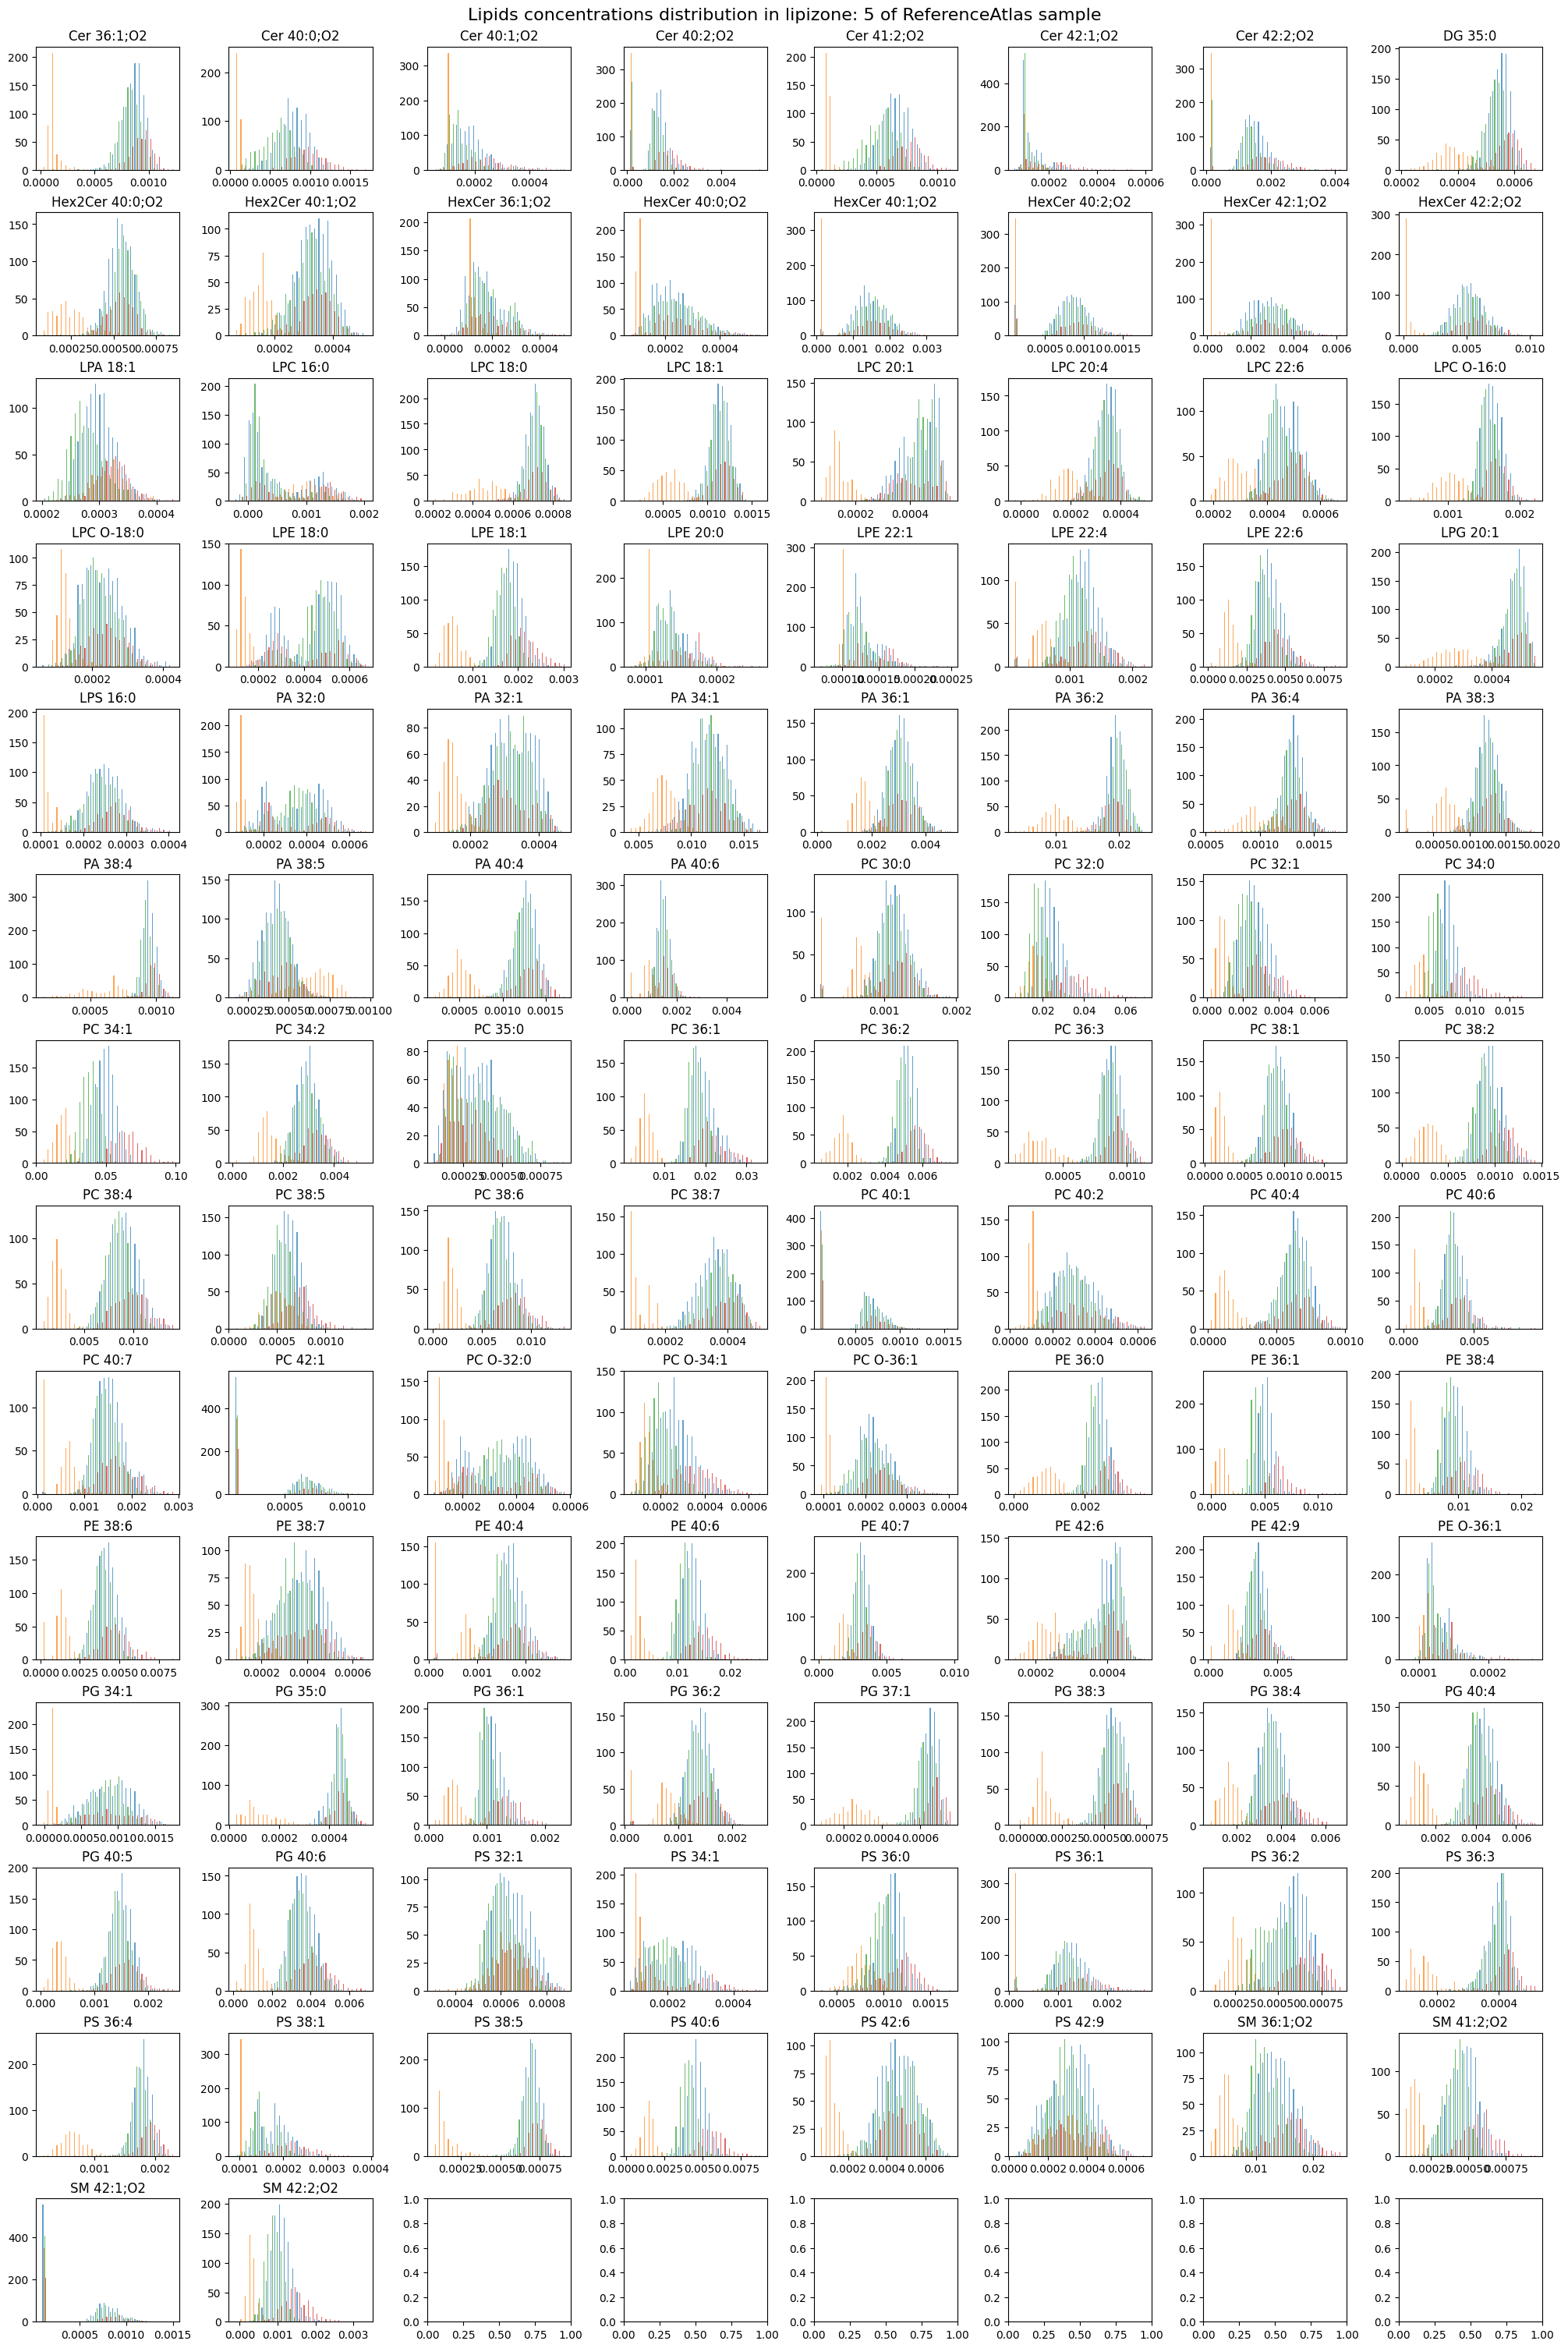

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(14, 8, figsize=(20, 30), constrained_layout=True)
for i, lipid in enumerate(common_nodes):
    ax = axes[i // 8, i % 8]
    ax.hist([labelled_data[labelled_data['cluster_label'] == i][lipid] for i in np.unique(labels)], bins=30, alpha=0.7)
    ax.set_title(lipid)
fig.suptitle(f'Lipids concentrations distribution in lipizone: {lipizone_names.index(lipizone)} of ReferenceAtlas sample', fontsize=16)
plt.savefig(f'figures/histograms/histograms_lipizone_{lipizone_names.index(lipizone)}_3clusters.png')
#plt.show()